# Goals of this notebook
1. Speed up old code while verifying correctness
1. Evaluate effectiveness of GD on ICL ODEs.

In [208]:
import math
from math import exp
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

# GP sampling

## NP

In [209]:
# Sample from Gaussian processes
# Adapted from https://gist.github.com/neubig/e859ef0cc1a63d1c2ea4

def rbf_kernel(x1, x2, variance = 1):
    return exp(-1 * ((x1-x2) ** 2) / (2*variance))

def ou_kernel(x1, x2, variance = 1):
    return exp(-1 * abs(x1-x2) / variance)

def gram_matrix(xs, kernel=rbf_kernel):
    return [[kernel(x1,x2) for x2 in xs] for x1 in xs]

# Gaussian process defined on xs
def sample_gp(xs, kernel=rbf_kernel, shape=None, variance=1, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    kernel_var = lambda x1, x2: kernel(x1, x2, variance=variance)

    mean = [0 for _ in xs]
    gram = gram_matrix(xs, kernel_var)

    if shape is None:
        ys = rng.multivariate_normal(mean, gram)
    else:
        ys = rng.multivariate_normal(mean, gram, shape)
    
    return ys

(64, 25, 41)


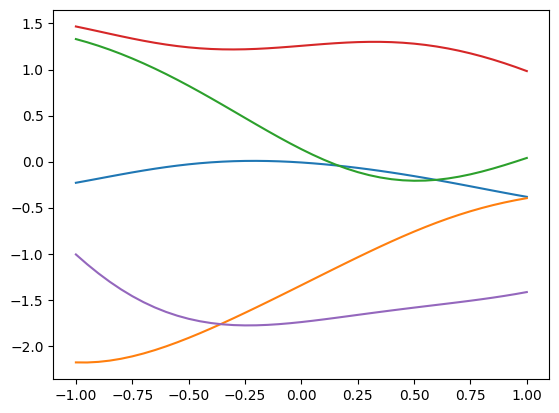

In [210]:
# Test
t = np.linspace(-1, 1, 41)
n_dims = 21
n_points = 25
batch_size = 64
rng = np.random.default_rng(seed=0)

c = sample_gp(t, shape=(batch_size, n_points), variance=1, rng=rng) # (batch_size, n_points, len(t))
print(c.shape)

# Plot
for i in range(5):
    plt.plot(t, c[0, i, :])

## Torch

In [215]:
# Sample from Gaussian processes
# Adapted from https://gist.github.com/neubig/e859ef0cc1a63d1c2ea4

def rbf_kernel(x1, x2, variance=1):
    return torch.exp(-1 * ((x1 - x2) ** 2) / (2*variance))

def ou_kernel(x1, x2, variance=1):
    return torch.exp(-1 * torch.abs(x1 - x2) / variance)

# xs: (N)
def gram_matrix(xs, kernel=rbf_kernel):
    x1 = xs.unsqueeze(1) # (N, 1)
    x2 = xs.unsqueeze(0) # (1, N)
    return kernel(x1, x2)

# Issue with numerical instability: torch doesn't handle PSD matrices, only PD.
"""
# xs: (N)
# shape: (...)
# Output: (..., N)
def sample_gp(xs, kernel=rbf_kernel, shape=None, variance=1, seed=None, eps=1e-6):

    if seed is not None:
        torch.manual_seed(seed)

    kernel_var = lambda x1, x2: kernel(x1, x2, variance=variance)

    mean = torch.zeros(len(xs), device=xs.device, dtype=xs.dtype)
    gram = gram_matrix(xs, kernel_var)
    gram += eps*torch.eye(gram.shape[-1], device=gram.device)

    if shape is None:
        ys = torch.distributions.MultivariateNormal(mean, gram).sample()
    else:
        ys = torch.distributions.MultivariateNormal(mean, gram).sample(shape)
    
    return ys
"""

# xs: (N)
# shape: (...)
# Output: (..., N)
def sample_gp(xs, kernel=rbf_kernel, shape=None, variance=1, seed=None):
    
    # Convert torch tensor to JAX array using dlpack
    xs_jax = jax.dlpack.from_dlpack(torch.utils.dlpack.to_dlpack(xs))
    
    # Create JAX kernel
    def kernel_jax(x1, x2, variance=variance):
        return jnp.exp(-1 * ((x1 - x2) ** 2) / (2*variance))
    
    # Compute gram matrix using JAX
    x1 = xs_jax[:, None]
    x2 = xs_jax[None, :]
    gram = kernel_jax(x1, x2)
    
    # Setup JAX random state
    if seed is not None:
        key = random.PRNGKey(seed)
    else:
        key = random.PRNGKey(0)
    
    # Sample using JAX's multivariate_normal
    mean = jnp.zeros(len(xs_jax))
    if shape is None:
        ys_jax = random.multivariate_normal(
            key, mean, gram, 
            method='svd'  # Use SVD method for better stability
        )
    else:
        ys_jax = random.multivariate_normal(
            key, mean, gram,
            shape=shape,
            method='svd'
        )
    
    # Convert back to torch using dlpack
    ys = torch.utils.dlpack.from_dlpack(jax.dlpack.to_dlpack(ys_jax))
    
    return ys

torch.Size([64, 25, 41])


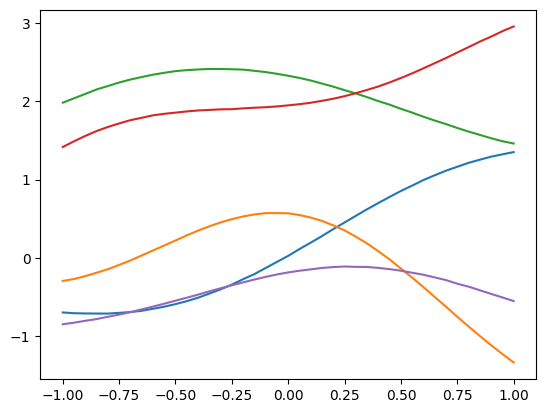

In [216]:
# Test
t = torch.linspace(-1, 1, 41)
n_dims = 21
n_points = 25
batch_size = 64
variance = 1
seed = 0

c = sample_gp(t, shape=(batch_size, n_points), variance=variance) # (batch_size, n_points, len(t))

# Plot
print(c.shape)
for i in range(5):
    plt.plot(t, c[0, i, :])

# Sample params

## NP

In [51]:
# eqn_class 0 = all terms
# eqn_class 1 = no a_2 term
# eqn_class 2 = no a_1 term
def sample_params(eqn_class=1, scale=1, size=None, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    if eqn_class != 2:
        a1 = rng.uniform(1-0.5*scale, 1+0.5*scale, size=size)
    else:
        a1 = np.zeros(size)
    if eqn_class != 1:
        a2 = rng.uniform(1-0.5*scale, 1+0.5*scale, size=size)
    else:
        a2 = np.zeros(size)
    a3 = rng.uniform(-scale, scale, size=size)
    a4 = rng.uniform(-scale, scale, size=size)

    return a1, a2, a3, a4

(64,)


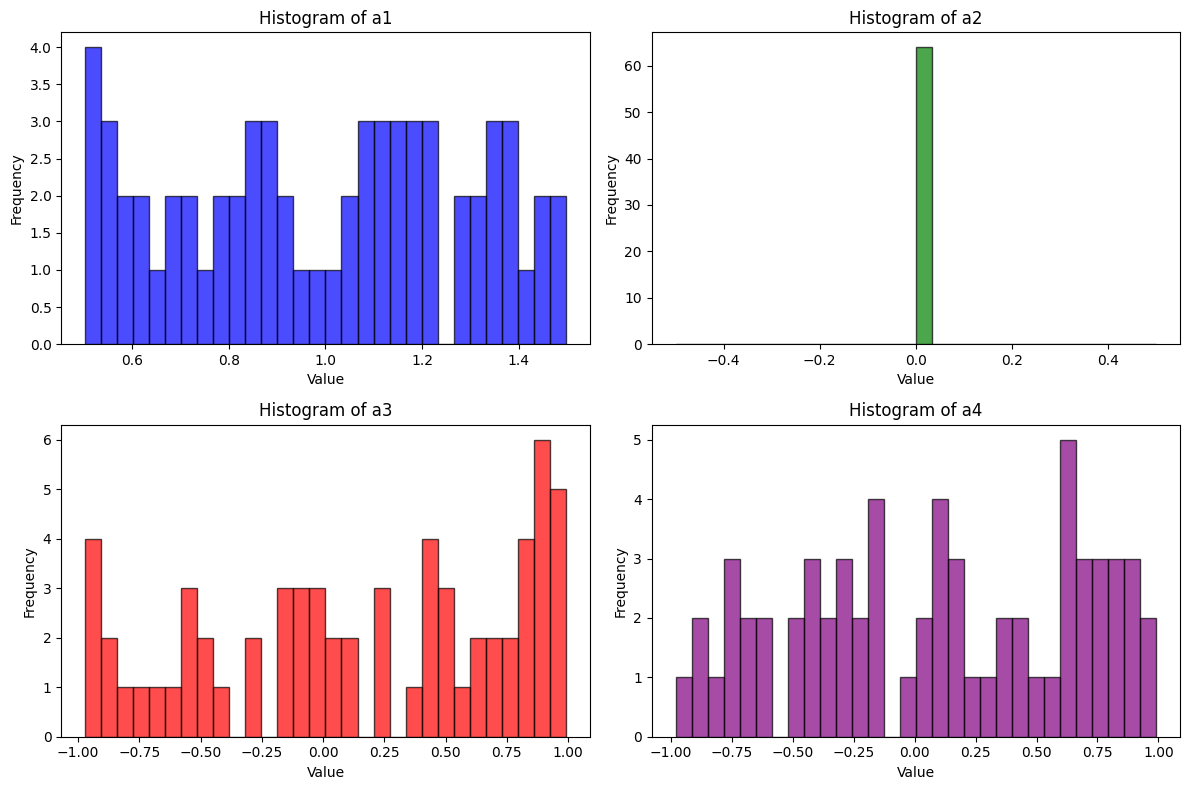

In [53]:
# Test
batch_size = 64
rng = np.random.default_rng(seed=0)

a1, a2, a3, a4 = sample_params(size=(batch_size), rng=rng)
print(a1.shape)

# Plot
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histograms
axes[0, 0].hist(a1, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Histogram of a1')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(a2, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Histogram of a2')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(a3, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Histogram of a3')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(a4, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Histogram of a4')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

## Torch

In [56]:
# eqn_class 0 = all terms
# eqn_class 1 = no a_2 term
# eqn_class 2 = no a_1 term
# size: (...)
# Output: a1, a2, a3, a4 = (...)
def sample_params(eqn_class=1, scale=1, size=None, seed=None, device="cuda"):
    if size is None:
        size = []

    if seed is not None:
        torch.manual_seed(seed)

    if eqn_class != 2:
        a1 = torch.empty(size, device=device).uniform_(1-0.5*scale, 1+0.5*scale)
    else:
        a1 = torch.zeros(size, device=device)
    
    if eqn_class != 1:
        a2 = torch.empty(size, device=device).uniform_(1-0.5*scale, 1+0.5*scale)
    else:
        a2 = torch.zeros(size, device=device)
    
    a3 = torch.empty(size, device=device).uniform_(-scale, scale)
    a4 = torch.empty(size, device=device).uniform_(-scale, scale)
    
    return a1, a2, a3, a4

torch.Size([64])


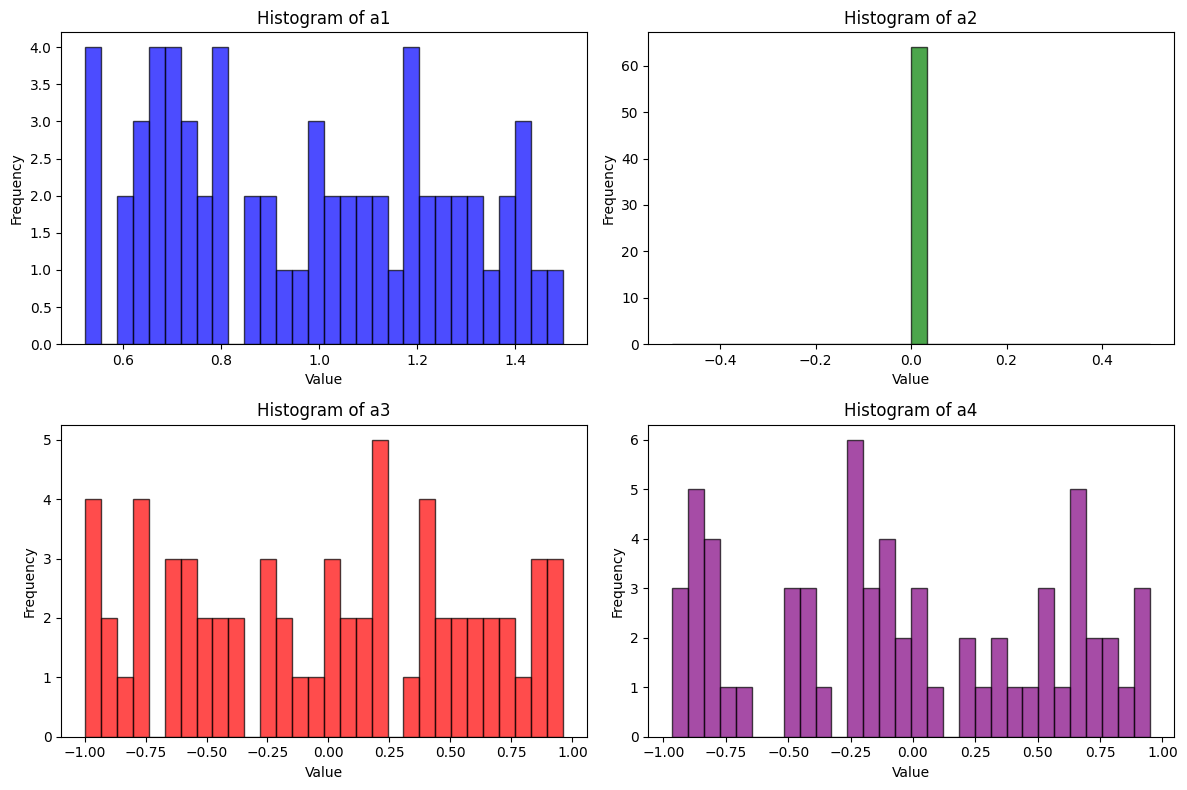

In [58]:
# Test
batch_size = 64
seed = 0

a1, a2, a3, a4 = sample_params(size=(batch_size), seed=0, device="cpu")
print(a1.shape)

# Plot
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histograms
axes[0, 0].hist(a1, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Histogram of a1')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(a2, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Histogram of a2')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(a3, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Histogram of a3')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(a4, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Histogram of a4')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

# Interpolate cheb

## NP

In [101]:
# Interpolate given function evaluated on Chebyshev points (of the 2nd kind)
# f = (..., N+1)
# x_eval = (N_eval)
# Output: f_eval = (..., N_eval)
def interpolate_cheb(f, x_eval):
    N = f.shape[-1]-1
    i = np.linspace(0, 1, N+1)
    to_cheb = lambda x : np.cos(np.pi*x)
    x = to_cheb(i) # Chebyshev points

    # Define weights
    w_x = np.zeros(N+1) # (N+1)
    w_x[::2] = 1
    w_x[1::2] = -1
    w_x[0] /= 2
    w_x[-1] /= 2

    # Define differences
    d_x = x_eval[None, ...] - x[..., None] # (N+1, n_eval)
    for eval_i in range(x_eval.shape[0]):
        arg_j = np.argmin(np.abs(d_x[..., eval_i]))
        if np.abs(d_x[arg_j, eval_i]) < 1e-14:
            d_x[..., eval_i] = 0
            d_x[arg_j, eval_i] = 1
        else:
            d_x[..., eval_i] = 1/d_x[..., eval_i]

    f_eval_num = np.einsum("...n,nm,n->...m", f, d_x, w_x)
    f_eval_denom = np.einsum("nm,n->m", d_x, w_x)
    return np.einsum("...m,m->...m", f_eval_num, 1/f_eval_denom)

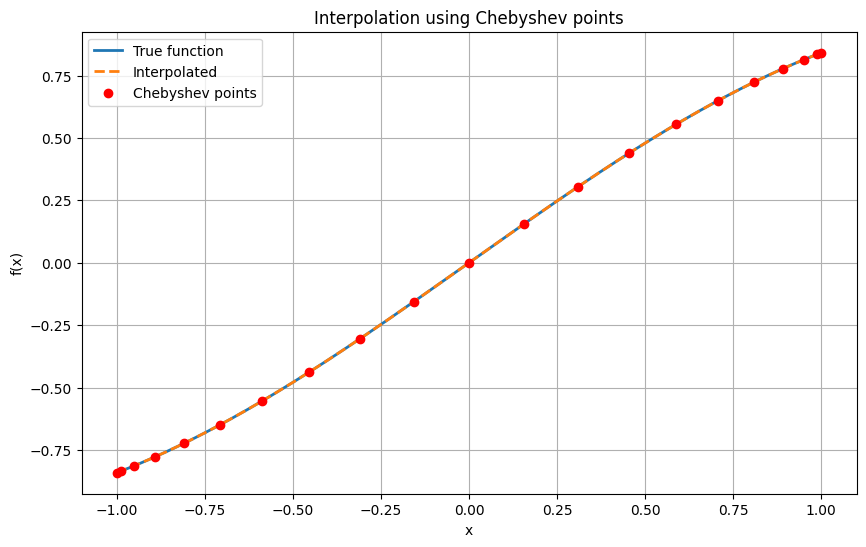

Max error: 6.661e-16
Mean error: 8.859e-17


In [107]:
# Target function
target_function = lambda x : np.sin(x)

# Chebyshev points of the second kind
def chebyshev_points(N):
    return np.cos(np.pi * np.linspace(0, 1, N + 1))

N = 20  # Number of Chebyshev points
N_eval = 1000  # Number of evaluation points
x_cheb = chebyshev_points(N)  # Chebyshev points
x_eval = np.linspace(-1, 1, N_eval)  # Points to evaluate the interpolation

# Evaluate the target function at Chebyshev points
f_cheb = target_function(x_cheb)

# Interpolate using the given function
f_interpolated = interpolate_cheb(f_cheb[None, :], x_eval)[0]

# True values of the function at x_eval
f_true = target_function(x_eval)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_eval, f_true, label="True function", linewidth=2)
plt.plot(x_eval, f_interpolated, "--", label="Interpolated", linewidth=2)
plt.scatter(x_cheb, f_cheb, color="red", label="Chebyshev points", zorder=5)
plt.legend()
plt.title("Interpolation using Chebyshev points")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

# Print error metrics
error = np.abs(f_interpolated - f_true)
print(f"Max error: {np.max(error):.3e}")
print(f"Mean error: {np.mean(error):.3e}")

## Torch

In [117]:
# f: (..., N+1)
# x_eval: (N_eval)
# Output: f_eval: (..., N_eval)
def interpolate_cheb(f, x_eval, eps=1e-14):
    N = f.shape[-1] - 1
    i = torch.linspace(0, 1, N+1, device=f.device, dtype=f.dtype)
    to_cheb = lambda x: torch.cos(math.pi*x)
    x = to_cheb(i).to(device=f.device) # Chebyshev points

    # Define weights
    w_x = torch.zeros(N+1, device=f.device, dtype=f.dtype)
    w_x[::2] = 1
    w_x[1::2] = -1
    w_x[0] = 0.5
    w_x[-1] = 0.5

    # Define difference matrix
    d_x = x_eval.unsqueeze(0) - x.unsqueeze(1) # (N+1, N_eval)

    # Handle numerical instability for small differences
    small_diff = torch.abs(d_x) < eps
    small_diff_max = torch.max(small_diff, dim=0).values
    # If small_diff, set the column to 0 and the entry to 1
    d_x = torch.where(
        small_diff_max[None, :],
        torch.zeros_like(d_x),
        1.0 / d_x
    )
    d_x[small_diff] = 1 # assumes no column has multiple small_diff

    # Interpolate
    f_eval_num = torch.einsum("...n,nm,n->...m", f, d_x, w_x)
    f_eval_denom = torch.einsum("nm,n->m", d_x, w_x)

    return f_eval_num / f_eval_denom

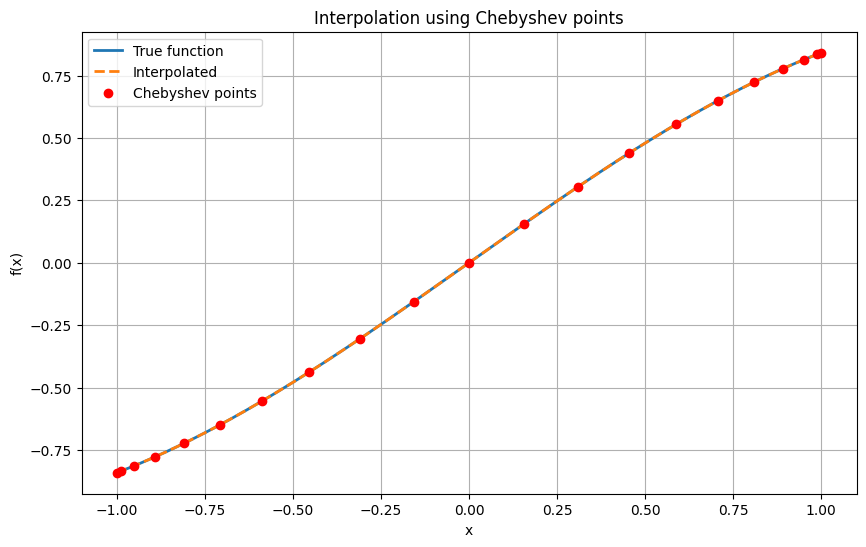

Max error: 6.661e-16
Mean error: 8.628e-17


In [122]:
# Target function
target_function = lambda x : torch.sin(x)

# Chebyshev points of the second kind
def chebyshev_points(N):
    return torch.cos(torch.pi * torch.linspace(0, 1, N + 1, dtype=torch.float64))

N = 20  # Number of Chebyshev points
N_eval = 1000  # Number of evaluation points
x_cheb = chebyshev_points(N).to(device="cpu", dtype=torch.float64)  # Chebyshev points
x_eval = torch.linspace(-1, 1, N_eval, dtype=torch.float64)  # Points to evaluate the interpolation

# Evaluate the target function at Chebyshev points
f_cheb = target_function(x_cheb)

# Interpolate using the given function
f_interpolated = interpolate_cheb(f_cheb.unsqueeze(0), x_eval).squeeze(0)

# True values of the function at x_eval
f_true = target_function(x_eval)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_eval, f_true, label="True function", linewidth=2)
plt.plot(x_eval, f_interpolated, "--", label="Interpolated", linewidth=2)
plt.scatter(x_cheb, f_cheb, color="red", label="Chebyshev points", zorder=5)
plt.legend()
plt.title("Interpolation using Chebyshev points")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

# Print error metrics
error = torch.abs(f_interpolated - f_true)
print(f"Max error: {torch.max(error):.3e}")
print(f"Mean error: {torch.mean(error):.3e}")

# Cheb

## NP

In [184]:
# Manually define the spectral differentiation matrix on n+1 Chebyshev nodes
def cheb(n, x=None):
    if x is None:
        to_cheb = lambda x : np.cos(np.pi*x)
        x = to_cheb(np.linspace(0, 1, n+1))

    D = np.zeros((n+1, n+1))
    # Compute entries of D except for diag[1] through diag[n-1]
    for i in range(n+1):
        for j in range(n+1):
            c_i = 2 if (i == 0 or i == n) else 1
            c_j = 2 if (j == 0 or j == n) else 1
            if i == 0 and j == 0:
                D[i, j] = (2*n**2+1)/6
            elif i == n and j == n:
                D[i, j] = -(2*n**2+1)/6
            elif i != j:
                D[i, j] = c_i/c_j * (-1)**(i+j) / (x[i] - x[j])
    
    # For numerical accuracy, compute the remaining diagonal entries
    for i in range(1, n):
        D[i, i] = -np.sum(D[i, :])

    return D, x

In [169]:
# Test
n = 6
cheb_np, _ = cheb(n)

## Torch

In [195]:
def cheb(n, x=None, device="cuda", dtype=torch.float32):
    if x is None:
        t = torch.linspace(0, 1, n, dtype=dtype, device=device)
        x = torch.cos(torch.pi * t)

    # Initialize D matrix
    D = torch.zeros((n, n), dtype=dtype, device=device)
    
    # Handle the corner elements first
    D[0, 0] = (2*(n-1)**2 + 1) / 6
    D[n-1, n-1] = -(2*(n-1)**2 + 1) / 6
    
    # Compute c arrays (multipliers for endpoints)
    c = torch.ones(n, dtype=dtype, device=device)
    c[0] = 2
    c[n-1] = 2
    
    # Compute off-diagonal elements
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i, j] = (c[i]/c[j]) * ((-1)**(i+j)) / (x[i] - x[j])
    
    # Compute remaining diagonal elements
    for i in range(1, n-1):
        D[i, i] = -D[i, :].sum()
    
    return D, x

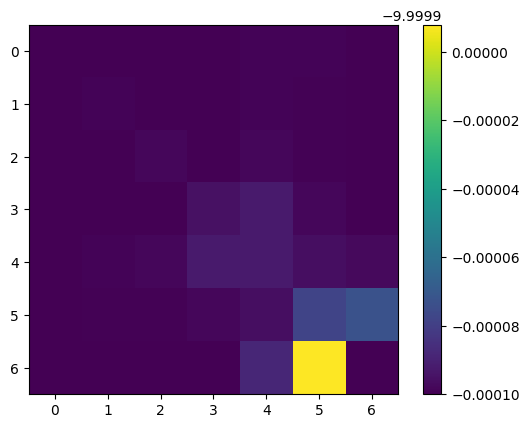

In [179]:
# Test
n = 7
cheb_torch, _ = cheb(n, dtype=torch.float64)

cheb_err = np.abs(cheb_torch.cpu().numpy() - cheb_np)
cheb_err = np.log10(cheb_err+1e-10)

# Plot the heatmap
plt.imshow(cheb_err, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

# Pseudospectral solve

## NP

In [191]:
# c_1 = (num_examples, N+1)
# c_2 = (num_examples, N+1)
# u_0 = (num_examples)
# u = (num_examples, N+1)
# a1, a2, a3, a4 = (num_examples)
def pseudospectral_solve_batch(a_1, a_2, a_3, a_4, u_0, c_1, c_2, do_reshape=True):
    # TODO how to handle when N is odd?
    N = c_1.shape[-1]-1
    if do_reshape:
        num_examples_shape = c_1.shape[:-1]
        a_1 = a_1.reshape(-1)
        a_2 = a_2.reshape(-1)
        a_3 = a_3.reshape(-1)
        a_4 = a_4.reshape(-1)
        u_0 = u_0.reshape(-1)
        c_1 = c_1.reshape(-1, N+1)
        c_2 = c_2.reshape(-1, N+1)
    num_examples = c_1.shape[0]
    D, _ = cheb(N) # (N+1, N+1)
    
    vectdiag = np.vectorize(np.diag, signature='(n)->(n,n)')
    
    # Solve linear system
    e_n2 = np.zeros(N+1); e_n2[N//2] = 1 # (N+1)
    b = a_1[:, None]*c_1 + a_4[:, None]*np.ones((num_examples, N+1)) + a_3[:, None]*u_0[:, None]*e_n2[None, :] # (num_examples, N+1)
    M = D[None, ...] - a_3[:, None, None]*np.eye(N+1)[None, ...] + a_3[:, None, None]*np.diag(e_n2)[None, ...] - a_2[:, None, None]*vectdiag(c_2) # (num_examples, N+1, N+1)
    u = np.linalg.solve(M, b)

    if do_reshape:
        u = u.reshape(*num_examples_shape, -1)
    return u

In [192]:
# Test parameters
batch_size = 2
n_points = 3
N_cheb = 4  # This means N+1 = 5 points total

# Fix random seed for reproducibility
rng = np.random.default_rng(42)

# Create test inputs
a1 = rng.uniform(0.5, 1.5, (batch_size,))
a2 = np.zeros((batch_size,))  # For eqn_class=1
a3 = rng.uniform(-1, 1, (batch_size,))
a4 = rng.uniform(-1, 1, (batch_size,))

# Create inputs with proper broadcasting
a1_tiled = np.tile(a1.reshape(-1, 1), (1, n_points))
a2_tiled = np.tile(a2.reshape(-1, 1), (1, n_points))
a3_tiled = np.tile(a3.reshape(-1, 1), (1, n_points))
a4_tiled = np.tile(a4.reshape(-1, 1), (1, n_points))

# Sample u0
u0 = rng.uniform(-1, 1, (batch_size, n_points))

# Create c1 and c2
c1 = rng.normal(0, 1, (batch_size, n_points, N_cheb + 1))
c2 = rng.normal(0, 1, (batch_size, n_points, N_cheb + 1))

# Test basic functionality with do_reshape=True
u = pseudospectral_solve_batch(
    a1_tiled, a2_tiled, a3_tiled, a4_tiled,
    u0, c1, c2
)

# Basic tests
assert u.shape == (batch_size, n_points, N_cheb + 1)
assert not np.isnan(u).any(), "Solution contains NaN values"
assert not np.isinf(u).any(), "Solution contains infinite values"

# Test reshaping behavior
# When do_reshape=False, we need to flatten all inputs properly
flat_u = pseudospectral_solve_batch(
    a1_tiled.reshape(-1),
    a2_tiled.reshape(-1),
    a3_tiled.reshape(-1),
    a4_tiled.reshape(-1),
    u0.reshape(-1),
    c1.reshape(-1, N_cheb + 1),
    c2.reshape(-1, N_cheb + 1),
    do_reshape=False
)
assert flat_u.shape == (batch_size * n_points, N_cheb + 1)

# Test if reshaping gives same results
reshaped_u = flat_u.reshape(batch_size, n_points, N_cheb + 1)
np.testing.assert_allclose(u, reshaped_u, rtol=1e-10)

u_np = u

## Torch

In [198]:
def pseudospectral_solve_batch(a_1, a_2, a_3, a_4, u_0, c_1, c_2, device="cuda", dtype=torch.float32):
    
    # Get dimensions
    N = c_1.shape[-1]
    num_examples_shape = c_1.shape[:-1]
    a_1 = a_1.reshape(-1)
    a_2 = a_2.reshape(-1)
    a_3 = a_3.reshape(-1)
    a_4 = a_4.reshape(-1)
    u_0 = u_0.reshape(-1)
    c_1 = c_1.reshape(-1, N)
    c_2 = c_2.reshape(-1, N)
    
    num_examples = c_1.shape[0]
    
    # Get Chebyshev differentiation matrix
    D, _ = cheb(N, device=device, dtype=dtype)
    
    # Create e_n2 vector
    e_n2 = torch.zeros(N, dtype=dtype, device=device)
    e_n2[(N-1)//2] = 1 # assuming N is odd
    
    # Create diagonalized version of c_2
    c_2_diag = torch.zeros(num_examples, N, N, dtype=dtype, device=device)
    c_2_diag.as_strided(c_2.shape, 
                       (c_2_diag.stride(0), c_2_diag.stride(1) + c_2_diag.stride(2)),
                       storage_offset=0)[:] = c_2
    
    # Compute right-hand side b
    # b = a_1[:, None]*c_1 + a_4[:, None]*ones + a_3[:, None]*u_0[:, None]*e_n2
    ones = torch.ones((num_examples, N), dtype=dtype, device=device)
    b = (a_1.unsqueeze(1) * c_1 + 
         a_4.unsqueeze(1) * ones + 
         a_3.unsqueeze(1) * u_0.unsqueeze(1) * e_n2.unsqueeze(0))
    
    # Compute system matrix M
    # M = D - a_3*eye + a_3*diag(e_n2) - a_2*diag(c_2)
    eye = torch.eye(N, dtype=dtype, device=device)
    M = (D.unsqueeze(0) + 
         (-a_3.unsqueeze(1).unsqueeze(2) * eye.unsqueeze(0)) + 
         (a_3.unsqueeze(1).unsqueeze(2) * torch.diag(e_n2).unsqueeze(0)) + 
         (-a_2.unsqueeze(1).unsqueeze(2) * c_2_diag))
    
    # Solve the system
    u = torch.linalg.solve(M, b)
    
    # Reshape output
    u = u.reshape(*num_examples_shape, -1)
    
    return u

In [207]:
u_torch = pseudospectral_solve_batch(
    torch.tensor(a1_tiled, device="cuda", dtype=torch.float64),
    torch.tensor(a2_tiled, device="cuda", dtype=torch.float64),
    torch.tensor(a3_tiled, device="cuda", dtype=torch.float64),
    torch.tensor(a4_tiled, device="cuda", dtype=torch.float64),
    torch.tensor(u0, device="cuda", dtype=torch.float64),
    torch.tensor(c1, device="cuda", dtype=torch.float64),
    torch.tensor(c2, device="cuda", dtype=torch.float64),
    device="cuda",
    dtype=torch.float64,
)

# Compare
pseudospectral_err = torch.max(torch.abs(u_torch - torch.tensor(u_np, device="cuda", dtype=torch.float64))).cpu().numpy()
print(f"Max error: {pseudospectral_err:.3e}")

Max error: 1.155e-14


In [13]:
def squared_error(y_pred, y):
    return (y - y_pred).square()

def mean_squared_error(y_pred, y):
    return (y - y_pred).square().mean()

In [14]:
class DataSampler:
    def __init__(self, n_dims, name=None, **kwargs):
        self.n_dims = n_dims
        self.name = name

    # Sample = (b l d)
    def sample(self, n_points, batch_size):
        raise NotImplementedError

# Sample parameters for ODE, initial condition, and forcing function
# Solve ODE on [-1, 1] with pseudospectral method
class ODEOperatorSampler(DataSampler):
    def __init__(
        self,
        n_dims,
        c_sampling="equispaced", # equispaced, cheb, randt
        # u_sampling="randt", # randt, vect
        eqn_class=0, # 0, 1, 2
        operator_scale=1,
        sampling_mode="equispaced",
        gp_length=1,
        u0_scale=1,
        seed=0,
        device="cuda",
        **kwargs
    ):
        super().__init__(
            n_dims=n_dims,
            name="ode_operator",
            **kwargs
        )
        self.c_sampling = c_sampling
        self.gp_length = gp_length
        self.u0_scale = u0_scale

        # Cheb
        self.n_cheb = 40
        self.to_cheb = lambda x : np.cos(np.pi*x)
        self.t_cheb = self.to_cheb(np.linspace(0, 1, self.n_cheb+1))

        # Equation
        self.eqn_class = eqn_class
        self.operator_scale = operator_scale

        self.seed = seed
        self.device = device
        self.generator = np.random.default_rng(seed=seed)

    def sample(self, n_points, batch_size, n_dims_truncated=None):
        n_samples = n_dims_truncated

        # Define t_eval based on sampling
        if self.c_sampling == "equispaced":
            t_eval = np.linspace(-1, 1, n_samples)
        elif self.c_sampling == "cheb":
            t_eval = self.to_cheb(np.linspace(0, 1, n_samples))
        elif self.c_sampling == "randt":
            t_eval = self.generator.uniform(-1, 1, n_samples)
        t = np.concatenate([self.t_cheb, t_eval])

        # Sample c
        c = sample_gp(t, shape=(batch_size, n_points), variance=self.gp_length, rng=self.generator) # (batch_size, n_points, len(t))
        c_cheb = c[:, :, :self.n_cheb+1] # (batch_size, n_points, n_cheb+1)
        c_eval = c[:, :, self.n_cheb+1:] # (batch_size, n_points, n_samples)

        # Sample u0
        u0 = self.generator.uniform(-self.u0_scale, self.u0_scale, (batch_size, n_points)) # (batch_size, n_points)

        # Sample equation parameters
        if self.eqn_class in [0, 1, 2]:
            a1, a2, a3, a4 = sample_params(
                eqn_class=self.eqn_class,
                size=(batch_size),
                scale=self.operator_scale,
                rng=self.generator
            )
        else:
            print(f"eqn_class {self.eqn_class} not implemented in ODEOperator")
            raise NotImplementedError

        # Solve for u pseudospectrally on [-1, 1]
        if self.eqn_class in [0, 1, 2]:
            u_cheb = pseudospectral_solve_batch(
                np.tile(a1.reshape(-1, 1), (1, n_points)),
                np.tile(a2.reshape(-1, 1), (1, n_points)),
                np.tile(a3.reshape(-1, 1), (1, n_points)),
                np.tile(a4.reshape(-1, 1), (1, n_points)),
                u0,
                c_cheb,
                c_cheb,
            ) # (batch_size, n_points, n_cheb+1)

        # Raw task data
        task_data = {}
        task_data["c_cheb"] = c_cheb # (batch_size, n_points, n_cheb+1)
        task_data["c_eval"] = c_eval # (batch_size, n_points, n_samples)
        task_data["u0"] = u0 # (batch_size, n_points)
        task_data["operator_params"] = (a1, a2, a3, a4)
        task_data["u_cheb"] = u_cheb # (batch_size, n_points, N_cheb+1)

        return task_data

In [15]:
n_dims = 21
n_points = 25
batch_size = 64

sampler = ODEOperatorSampler(
    n_dims,
    c_sampling="equispaced",
    eqn_class=0,
    operator_scale=1,
    u0_scale=1,
    seed=0,
    device="cuda",
)

In [16]:
task_data = sampler.sample(n_points, batch_size, n_dims_truncated=n_dims)
task_data.keys()

dict_keys(['c_cheb', 'c_eval', 'u0', 'operator_params', 'u_cheb'])

In [17]:
task_data["c_cheb"].shape

(64, 25, 41)

In [18]:
task_data["c_eval"].shape

(64, 25, 21)

In [19]:
task_data["u0"].shape

(64, 25)

In [20]:
task_data["u_cheb"].shape

(64, 25, 41)

In [21]:
class Task:
    def __init__(self, name=None, **kwargs):
        self.name = name

    # For use in training, includes formatting. Output a dictionary of tensors: prefix, x, and y.
    def evaluate(self, x):
        raise NotImplementedError

    # Can be used separately from training, without formatting.
    def out(self, x):
        raise NotImplementedError

    @staticmethod
    def get_metric():
        raise NotImplementedError

    @staticmethod
    def get_training_metric():
        raise NotImplementedError

class ODEOperatorICL(Task):
    def __init__(
        self,
        noise_variance=0,
        seed=0,
        device="cuda",
        **kwargs
    ):
        super().__init__(name="ode_operator", **kwargs)
        self.device = device
        self.rng = np.random.default_rng(seed=seed)
        self.noise_variance = noise_variance

    def evaluate(self, task_data):
        c_cheb = task_data["c_cheb"] # (batch_size, n_points, n_cheb+1)
        c_eval = task_data["c_eval"] # (batch_size, n_points, n_samples)
        B, L, D = c_eval.shape

        # Cheb interpolate onto sampled points
        t_eval = self.rng.uniform(-1, 1, B)
        u_cheb = task_data["u_cheb"]
        u_eval = interpolate_cheb(u_cheb, t_eval) # (batch_size, n_points, n_samples)
        u_eval = u_eval[np.arange(B), :, np.arange(B)] # (batch_size, n_points)

        if self.noise_variance != 0:
            u_ood = u_eval + self.noise_variance*self.rng.standard_normal(u_eval.shape)
        else:
            u_ood = u_eval

        # Inputs: [(c, u0, 1), u_ood]
        # Outputs: [u_ood]
        in_data = torch.zeros((B, 2*L-1, D+3)).to(device=self.device) # (B, 2L-1, D+3)
        in_data[:, ::2, :-3] = torch.tensor(c_eval)
        in_data[:, ::2, -3] = torch.tensor(task_data["u0"])
        in_data[:, ::2, -2] = 1
        in_data[:, 1::2, -1] = torch.tensor(u_ood)[:, :-1]

        out_data = torch.tensor(u_eval).to(device=self.device).unsqueeze(-1) # (B, L, 1)

        return {
            "in": in_data, # (B, 2L-1, D+3)
            "out": out_data, # (B, L, 1)
        }

    def get_metric():
        def metric(out_pred, out):
            assert out_pred[:, ::2, -1:].shape == out.shape
            return squared_error(out_pred[:, ::2, -1:], out)
        return metric

    def get_training_metric():
        def training_metric(out_pred, out):
            assert out_pred[:, ::2, -1:].shape == out.shape
            return mean_squared_error(out_pred[:, ::2, -1:], out)
        return training_metric

In [22]:
task = ODEOperatorICL(
    noise_variance=0,
    seed=0,
    device="cuda",
)

In [23]:
out = task.evaluate(task_data)

In [24]:
out["in"][0].shape

torch.Size([49, 24])

In [25]:
out["out"].shape

torch.Size([64, 25])